# Jores et al 2021 Training 
**Authorship:**
Adam Klie, *05/18/2023*
***
**Description:**
Notebook to perform simple training of models on the Jores et al (2021) dataset. You can also use the `jores21_training.py` script as well if you want to run it that way.
***

In [66]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

In [1]:
import os
import logging
import torch
from copy import deepcopy 
import numpy as np
import pandas as pd
import seqdata as sd
import motifdata as md
from eugene import settings

In [2]:
settings.dataset_dir = "/cellar/users/aklie/data/eugene/jores21"
settings.output_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/output/revision/jores21"
settings.logging_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/logs/revision/jores21"
settings.config_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/configs/jores21"
settings.verbosity = logging.ERROR

# Load in the `leaf`, `proto` and `combined` `SeqData`s 

In [3]:
# Load in the preprocessed training data
sdata_leaf = sd.read(os.path.join(settings.dataset_dir, "leaf_processed_train.h5sd"))
sdata_proto = sd.read(os.path.join(settings.dataset_dir, "proto_processed_train.h5sd"))
sdata_combined = sd.concat([sdata_leaf, sdata_proto], keys=["leaf", "proto"])
sdata_leaf, sdata_proto, sdata_combined

(SeqData object with = 65004 seqs
 seqs = (65004,)
 names = (65004,)
 rev_seqs = None
 ohe_seqs = (65004, 4, 170)
 ohe_rev_seqs = None
 seqs_annot: 'GC', 'barcodes', 'batch', 'chromosome', 'end', 'enrichment', 'gene', 'mutations', 'set', 'sp', 'start', 'strand', 'train_val', 'type'
 pos_annot: None
 seqsm: None
 uns: None,
 SeqData object with = 68213 seqs
 seqs = (68213,)
 names = (68213,)
 rev_seqs = None
 ohe_seqs = (68213, 4, 170)
 ohe_rev_seqs = None
 seqs_annot: 'GC', 'barcodes', 'batch', 'chromosome', 'end', 'enrichment', 'gene', 'mutations', 'set', 'sp', 'start', 'strand', 'train_val', 'type'
 pos_annot: None
 seqsm: None
 uns: None,
 SeqData object with = 133217 seqs
 seqs = (133217,)
 names = (133217,)
 rev_seqs = None
 ohe_seqs = (133217, 4, 170)
 ohe_rev_seqs = None
 seqs_annot: 'GC', 'barcodes', 'batch', 'chromosome', 'end', 'enrichment', 'gene', 'mutations', 'set', 'sp', 'start', 'strand', 'train_val', 'type'
 pos_annot: None
 seqsm: None
 uns: None)

In [4]:
# Grab motifs
core_promoter_elements = md.read_meme(os.path.join(settings.dataset_dir, "CPEs.meme"))
tf_clusters = md.read_meme(os.path.join(settings.dataset_dir, "TF-clusters.meme"))

# Smush them together, make function in the future
all_motifs = deepcopy(core_promoter_elements)
for motif in tf_clusters:
    all_motifs.add_motif(motif)
all_motifs

MotifSet with 78 motifs

In [5]:
import yaml
import importlib

In [6]:
from eugene import models
importlib.reload(models)

<module 'eugene.models' from '/cellar/users/aklie/projects/ML4GLand/EUGENe/eugene/models/__init__.py'>

In [7]:
def load_config(config_path):
    with open(config_path, "r") as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
    module_name = config.pop("module")
    model_params = config.pop("model")
    arch_name = model_params["arch_name"]
    arch = model_params["arch"]
    model_type = getattr(importlib.import_module("eugene.models"), arch_name)
    model = model_type(**arch)
    module_type = getattr(importlib.import_module("eugene.models"), module_name)
    module = module_type(model, **config)
    return module

In [8]:
model = load_config("/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/configs/jores21/cnn.yaml")

In [9]:
models.init_motif_weights(
    model,
    layer_name="arch.conv1d_tower.layers.0",
    motifs=all_motifs
)

In [10]:
# Double check that layer
from eugene.models.base._utils import get_layer
get_layer(model, 'arch.conv1d_tower.layers.0').weight[0].T

tensor([[0.5100, 1.5060, 0.4780, 1.5060],
        [0.6300, 1.5940, 0.7960, 0.9820],
        [0.9960, 1.2120, 0.7880, 1.0040],
        [0.4940, 2.6200, 0.3020, 0.5820],
        [0.0400, 0.0080, 0.0080, 3.9440],
        [3.8720, 0.0000, 0.0000, 0.1280],
        [0.0080, 0.0560, 0.0240, 3.9120],
        [3.9680, 0.0000, 0.0080, 0.0240]], grad_fn=<PermuteBackward0>)

In [11]:
from eugene import dataload as dl

In [12]:
train_idx = np.where(sdata_leaf["train_val"] == True)[0]
val_idx = np.where(sdata_leaf["train_val"] == False)[0]
train_sdataset = dl.SequenceDataset(
    seqs=sdata_leaf.ohe_seqs[train_idx],
    targets=sdata_leaf["enrichment"].values[train_idx]
)
val_sdataset = dl.SequenceDataset(
    seqs=sdata_leaf.ohe_seqs[val_idx],
    targets=sdata_leaf["enrichment"].values[val_idx]
)

In [13]:
train_sdataloader = train_sdataset.to_dataloader(batch_size=128, shuffle=True, num_workers=4, drop_last=True)
val_sdataloader = val_sdataset.to_dataloader(batch_size=128, shuffle=False, num_workers=4, drop_last=True)

In [14]:
from eugene import train
importlib.reload(train)
from eugene import train

In [15]:
from pytorch_lightning.loggers import WandbLogger, CSVLogger, TensorBoardLogger

In [16]:
logger = CSVLogger(save_dir=settings.logging_dir, name="cnn", version="test")

In [17]:
os.path.join(logger.save_dir, logger.name, logger.version, "checkpoints")

'/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/logs/revision/jores21/cnn/test/checkpoints'

In [18]:
logger.log_dir + "check"

'/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/logs/revision/jores21/cnn/testcheck'

In [21]:
logger.save_dir

In [75]:
import wandb

In [25]:
trainer = train.fit(
    model=model, 
    train_dataloader=train_sdataloader,
    val_dataloader=val_sdataloader,
    gpus=1, 
    epochs=2,
    logger="csv",
    log_dir=settings.logging_dir,
    name="grace",
    version="leaf",
    return_trainer=True
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


No seed set


/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/pytorch_lightning/loggers/csv_logs.py:58: UserWarning: Experiment logs directory /cellar/users/aklie/projects/ML4GLand/EUGENe_paper/logs/revision/jores21/grace/leaf exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  f"Experiment logs directory {self.log_dir} exists and is not empty."
Set SLURM handle signals.

  | Name         | Type    | Params
-----------------------------------------
0 | arch         | CNN     | 3.0 M 
1 | train_metric | R2Score | 0     
2 | val_metric   | R2Score | 0     
3 | test_metric  | R2Score | 0     
-----------------------------------------
3.0 M     Trainable params
0         Non-trainable params
3.0 M     Total params
11.971    Total estimated model params size (MB)
/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint d

/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [22]:
import wandb

In [24]:
wandb.finish()

epoch,▁▁▁▁▁▁▁▁▁▁▁███████████
lr-Adam,▁▁
train_loss,█▄▇▄▆▄▄▄▃▃▃▂▃▁▃▂▂▃
train_loss_epoch,█▁
train_r2score_epoch,▁█
trainer/global_step,▁▁▂▂▃▃▃▄▄▄▄▄▅▅▅▆▆▆▇▇████
val_loss_epoch,█▁
val_r2score_epoch,▁█
epoch,1
lr-Adam,0.001
train_loss,1.17454


In [23]:
from eugene import plot as pl

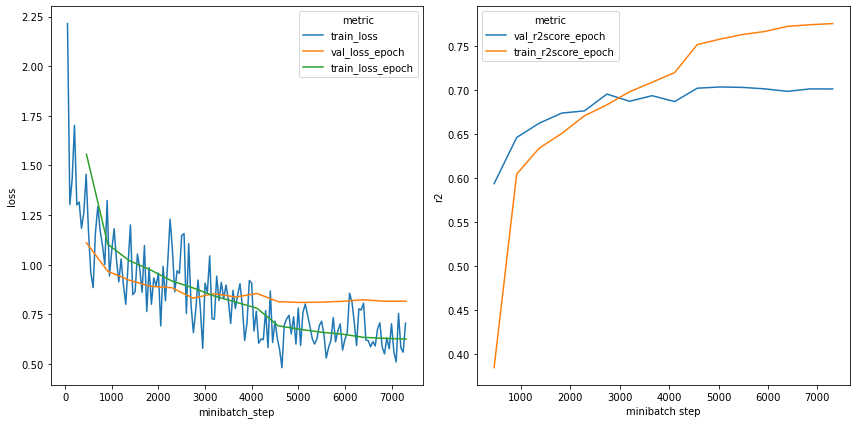

In [41]:
pl.training_summary(os.path.join(settings.logging_dir, "grace", "leaf"))

In [23]:
model.optimizer.state_dict

<function torch.optim.optimizer.Optimizer.state_dict(self)>

In [ ]:
from pytorch_lightning import seed_everything

# Function for instantiating a new randomly initialized model
def prep_new_model(
    seed,
    arch,
    config
):
    # Instantiate the model
    model = eu.models.load_config(
        arch=arch,
        model_config=config
    )
    
    seed_everything(seed)
    
    # Initialize the model prior to conv filter initialization
    eu.models.init_weights(model)

    # Initialize the conv filters
    if arch == "Jores21CNN":
        module_name, module_number, kernel_name, kernel_number = "biconv", None, "kernels", 0, 
    elif arch in ["CNN", "Hybrid"]:
        module_name, module_number, kernel_name, kernel_number = "convnet", 0, None, None
    eu.models.init_from_motifs(
        model, 
        all_motifs, 
        module_name=module_name,
        module_number=module_number,
        kernel_name=kernel_name,
        kernel_number=kernel_number
    )

    # Return the model
    return model 

In [ ]:
# Instantiate a test model to make sure this is working properly
test_model = prep_new_model(0, "Jores21CNN", os.path.join(eu.settings.config_dir, "Jores21CNN.yaml"))

## Train a prototype model 

In [ ]:
# Train 5 models with 5 different random initializations
model_types = ["CNN", "Hybrid", "Jores21CNN"]
model_names = ["ssCNN", "ssHybrid", "Jores21CNN"]
trials = 1
for model_name, model_type in zip(model_names, model_types):
    for trial in range(1, trials+1):
        print(f"{model_name} trial {trial}")

        # Initialize the model
        leaf_model = prep_new_model(
            arch=model_type, 
            config=os.path.join(eu.settings.config_dir, f"{model_name}.yaml"),
            seed=trial
        )

        # Train the model
        eu.train.fit(
            model=leaf_model, 
            sdata=sdata_leaf, 
            gpus=1, 
            target_keys="enrichment",
            train_key="train_val",
            epochs=1,
            batch_size=128,
            num_workers=0,
            name=model_name,
            seed=trial,
            version=f"leaf_trial_{trial}",
            weights_summary=None,
            verbosity=logging.ERROR
        )

        # Get predictions on the training data
        eu.evaluate.train_val_predictions(
            leaf_model,
            sdata=sdata_leaf, 
            target_keys="enrichment",
            train_key="train_val",
            name=model_name,
            version=f"leaf_trial_{trial}",
            prefix=f"{model_name}_trial_{trial}_"
        )

        # Make room for the next model 
        del leaf_model

# Save train and validation predictions
sdata_leaf.write_h5sd(os.path.join(eu.settings.output_dir, "leaf_train_predictions.h5sd"))

# Train proto models

In [ ]:
# Train 5 models with 5 different random initializations
model_types = ["CNN", "Hybrid", "Jores21CNN"]
model_names = ["ssCNN", "ssHybrid", "Jores21CNN"]
trials = 5
for model_name, model_type in zip(model_names, model_types):
    for trial in range(1, trials+1):
        print(f"{model_name} trial {trial}")

        # Initialize the model
        proto_model = prep_new_model(
            arch=model_type, 
            config=os.path.join(eu.settings.config_dir, f"{model_name}.yaml"),
            seed=trial
        )
        
        # Train the model
        eu.train.fit(
            model=proto_model, 
            sdata=sdata_proto, 
            gpus=1, 
            target_keys="enrichment",
            train_key="train_val",
            epochs=25,
            batch_size=128,
            num_workers=4,
            name=model_name,
            seed=trial,
            version=f"proto_trial_{trial}",
            verbosity=logging.ERROR,
            weights_summary=None
        )

        # Get predictions on the training data
        eu.evaluate.train_val_predictions(
            proto_model,
            sdata=sdata_proto, 
            target="enrichment",
            train_key="train_val",
            name=model_name,
            version=f"proto_trial_{trial}",
            prefix=f"{model_name}_trial_{trial}_"
        )

        # Make room for the next model
        del proto_model

# Save train and validation predictions        
sdata_proto.write_h5sd(os.path.join(eu.settings.output_dir, "proto_train_predictions.h5sd"))

# Train combined models

In [ ]:
# Train 5 models with 5 different random initializations
model_types = ["CNN", "Hybrid", "Jores21CNN"]
model_names = ["ssCNN", "ssHybrid", "Jores21CNN"]
trials = 5
for model_name, model_type in zip(model_names, model_types):
    for trial in range(1, trials+1):
        print(f"{model_name} trial {trial}")

        # Initialize the model
        combined_model = prep_new_model(
            arch=model_type, 
            config=os.path.join(eu.settings.config_dir, f"{model_name}.yaml"),
            seed=trial
        )

        # Train the model
        eu.train.fit(
            model=combined_model, 
            sdata=sdata_combined, 
            gpus=1, 
            target_keys="enrichment",
            train_key="train_val",
            epochs=25,
            batch_size=128,
            num_workers=4,
            name=model_name,
            seed=trial,
            version=f"combined_trial_{trial}",
            verbosity=logging.ERROR,
            weights_summary=None
        )

        # Get predictions on the training data
        eu.evaluate.train_val_predictions(
            combined_model,
            sdata=sdata_combined, 
            target="enrichment",
            train_key="train_val",
            name=model_name,
            version=f"combined_trial_{trial}",
            prefix=f"{model_name}_trial_{trial}_"
        )

        # Make room for the next model
        del combined_model

# Save train and validation predictions
sdata_combined.write_h5sd(os.path.join(eu.settings.output_dir, "combined_train_predictions.h5sd"))

---